In [16]:
import yaml
import torch
import torch.nn as nn
import numpy as np
import tqdm
import os
import argparse
from torch.backends import cudnn
from matplotlib import pyplot as plt

cudnn.benchmark = True

def delete_module(name):
    import sys
    del sys.modules[name]
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# delete_module('scorenet')
# from scorenet import Scorenet

In [3]:
# delete_module('critic')
# from critic import Criticnet

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
config_file = './test_config_mnist.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/nfs/rhea.dgp/u6/a/mrsalehi/.virtualenvs/prob-learn-proj/lib/python3.6/site-packages/ipykernel_launcher.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Namespace(data=Namespace(batch_size=32, cates=['0'], data_dir='data/MNIST-CP', dataset_scale=1, dataset_type='MNIST_CP', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=0, tr_max_sample_points=800, type='datasets.mnist_cp'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(epochs=100, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), seed=100, sigma_begin=1, sigma_end=0.01, sigma_num=10, type='trainers.ae_trainer_3D'), viz=Namespace(log_freq=10,

In [6]:
cfg.data

Namespace(batch_size=32, cates=['0'], data_dir='data/MNIST-CP', dataset_scale=1, dataset_type='MNIST_CP', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=0, tr_max_sample_points=800, type='datasets.mnist_cp')

In [7]:
cfg.trainer

Namespace(epochs=100, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), seed=100, sigma_begin=1, sigma_end=0.01, sigma_num=10, type='trainers.ae_trainer_3D')

In [8]:
cfg.models

Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128))

In [9]:
cfg.inference

Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1)

In [10]:
cfg.viz

Namespace(log_freq=10, save_freq=100, val_freq=100, viz_freq=5000)

# Train

In [11]:
from scorenet import Scorenet
from critic import Criticnet
from utils import get_opt, approx_jacobian_trace, set_random_seed, exact_jacobian_trace
from data_loader import get_data, get_data_mnist_cp
import random

In [12]:
set_random_seed(getattr(cfg.trainer, "seed", 666))

# load data
train_data = get_data_mnist_cp(cfg.data, 0)
tr_pts = train_data['tr_points'].unsqueeze(0)
te_pts = train_data['te_points'].unsqueeze(0)
tr_pts = tr_pts.to(device)
te_pts = te_pts.to(device)
tr_pts.requires_grad_()
te_pts.requires_grad_();

100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


Total number of data:4729
Min number of points: (train)600 (test)0


In [13]:
# sigmas
if hasattr(cfg.trainer, "sigmas"):
    sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
print("Sigma:, ", sigmas)

Sigma:,  [1.         0.59948425 0.35938137 0.21544347 0.12915497 0.07742637
 0.04641589 0.02782559 0.01668101 0.01      ]


In [14]:
# score net
score_net = Scorenet()
critic_net = Criticnet()
critic_net.to(device)
score_net.to(device)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

# training
start_epoch = 0
print("Start epoch: %d End epoch: %d" % (start_epoch, cfg.trainer.epochs))
k_iters = 10
e_iters = 10

colors = []
losses = []

for epoch in range(start_epoch, cfg.trainer.epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
    labels = torch.randint(0, len(sigmas), (1,), device=tr_pts.device)
#     used_sigmas = torch.tensor(np.array(sigmas))[-1].float().view(1, 1).cuda()
    used_sigmas = torch.tensor(np.array(sigmas))[-1].float().view(1, 1).to(device)
    
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * used_sigmas
    
    score_pred = score_net(perturbed_points, used_sigmas)
    critic_output = critic_net(perturbed_points, used_sigmas)
    
    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    
    cycle_iter = epoch % (k_iters + e_iters)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        print("Epoch (critic) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
        losses.append(cpu_loss)
        colors.append('blue')
    else:
        loss.backward()
        opt_scorenet.step()
        print("Epoch (score) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
        losses.append(cpu_loss)
        colors.append('red')

Start epoch: 0 End epoch: 100
Epoch (critic) 0 Loss=-0.06887 t1=-0.08123 t2=0.01236
Epoch (critic) 1 Loss=0.75153 t1=0.69320 t2=0.05833
Epoch (critic) 2 Loss=0.46862 t1=0.30254 t2=0.16608
Epoch (critic) 3 Loss=0.32016 t1=0.04007 t2=0.28009
Epoch (critic) 4 Loss=0.48596 t1=0.03429 t2=0.45168
Epoch (critic) 5 Loss=0.84922 t1=0.07115 t2=0.77808
Epoch (critic) 6 Loss=1.49500 t1=0.06025 t2=1.43475
Epoch (critic) 7 Loss=2.26040 t1=0.09474 t2=2.16566
Epoch (critic) 8 Loss=2.45622 t1=0.17567 t2=2.28055
Epoch (critic) 9 Loss=3.35793 t1=0.17547 t2=3.18247
Epoch (score) 10 Loss=5.84317 t1=0.13168 t2=5.71149
Epoch (score) 11 Loss=4.96572 t1=-0.49392 t2=5.45964
Epoch (score) 12 Loss=4.18707 t1=-0.95789 t2=5.14497
Epoch (score) 13 Loss=4.52369 t1=-1.30639 t2=5.83008
Epoch (score) 14 Loss=4.12315 t1=-1.57826 t2=5.70140
Epoch (score) 15 Loss=3.80664 t1=-1.85142 t2=5.65805
Epoch (score) 16 Loss=3.61936 t1=-2.06414 t2=5.68350
Epoch (score) 17 Loss=3.24885 t1=-2.24219 t2=5.49103
Epoch (score) 18 Loss=2.4

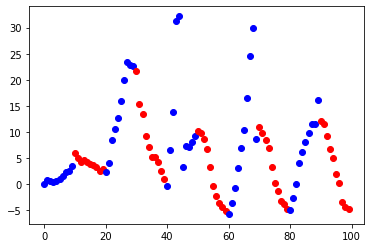

In [22]:
for i, (loss, color) in enumerate(zip(losses, colors)):
    plt.scatter(i, loss, color=color)